This notebook is used for the data analysis of the experiment "Optitrack and Leap swarm control"

I saved the values of the metrics computed by the mapping algorithm

In [118]:
data_folder = '..\\data_analysis\\data_analysis\\EXPERIMENT_PILOTS\\VALUES_STORED'

In [119]:
# needed to use modules/scripts from parent folder
import os,sys
print(sys.version)
sys.path.insert(1, os.path.join(sys.path[0], 'C:\\github\\HRI_mapping\\src'))

import HRI_mapping as HRI
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from settings.settings import get_settings
import sys
import json
import os
from matplotlib.backends.backend_pdf import PdfPages

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


In [120]:
# Not sure I even use that anymore
settings = get_settings()

In [121]:
datas_leap = [f for f in os.listdir(data_folder) if 'leap' in f]

In [122]:
# Get the data we saved from the experiments, especially the coefficients (correlation or correlation*SNR) for each subject and swarm maneuver

coeff = {}
for i,folder in enumerate(datas_leap):
    file_coeff_name = os.path.join(data_folder,folder,'coeff.json')     #for using corr * SNR
    # file_coeff_name = os.path.join(data_folder,folder,'covar.json')      # for using only the correlation
    with open(file_coeff_name) as file_coeff:
        coeff_data = json.load(file_coeff)
    coeff[i] = coeff_data

In [123]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='bottom')

In [124]:
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

In [125]:
# This was used for the previous figures we had.
# Cells bellow works for the new ones
# Not used anymore

#coeff_mean = {}
#coeff_std = {}
#for out in coeff[0].keys():
#    coeff_mean[out] = {}
#    coeff_std[out] = {}
#    for input_feat in coeff[0][out].keys():
#        list_feat_values = []
#        for subject in range(len(datas_leap)):
#            if np.sum(list(coeff[subject][out].values())) != 0:
#                list_feat_values.append(coeff[subject][out][input_feat]/np.sum(list(coeff[subject][out].values())))
#            else:
#                list_feat_values.append(0)
#        coeff_mean[out][input_feat] = np.mean(list_feat_values)
#        coeff_std[out][input_feat] = np.std(list_feat_values)

In [126]:
# Parameters to tune

thresh = 0.5         # Threshold : x% of the coefficients
n_selected_features = 20    # The maximum number of features we will add to reach the threshold (can be high)  
n_selected = 10       # How much input feats we want to plot

In [127]:
# This cell computes which features account together for more than x% of the coefficient 

coef_sum = {}   # Creates and initialize the dict
for out in coeff[0].keys():
    coef_sum[out] = {}
    for input_feat in coeff[0][out].keys():
        coef_sum[out][input_feat] = 0

for out in coeff[0].keys():
    for subject in range(len(datas_leap)):
        # These lines sort the features according to their coeff values (features for a specific subject and swarm motion)
        ind = np.argpartition(list(coeff[subject][out].values()), -n_selected_features)[-n_selected_features:]
        ind = ind[np.argsort(-np.array([list(coeff[subject][out].values())[i] for i in ind]))] # To sort the array in descending order
        name_ind = np.array(list(coeff[subject][out].keys()))[ind]
        
        coeff_data = [coeff[subject][out][n]/np.sum(list(coeff[subject][out].values())) for n in name_ind] # Coefficients values
        
        cumul_data = np.cumsum(coeff_data)   # Cumulative sum
        selected_indexes = np.where(cumul_data<thresh)[0]     # Apply the threshold
        #print(out, selected_indexes)
        
        if len(selected_indexes) == 0:
            selected_indexes = [-1]     # Will allow to select index 0 at next line
            
        for index in range(selected_indexes[-1]+2):    # This line is a bit strange... if selected_indexes=[0,1,2] I want to look at indexes 0,1,2 and 3 (due to how threshold is applied)
            if index < n_selected_features:
                input_feat = name_ind[index]
                coef_sum[out][input_feat] += 1      # We add one for each parameter selected
#print(coef_sum)

C:\Users\defoo\anaconda3\envs\hri\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\defoo\anaconda3\envs\hri\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


['input1', 'input2', 'input3', 'input4']


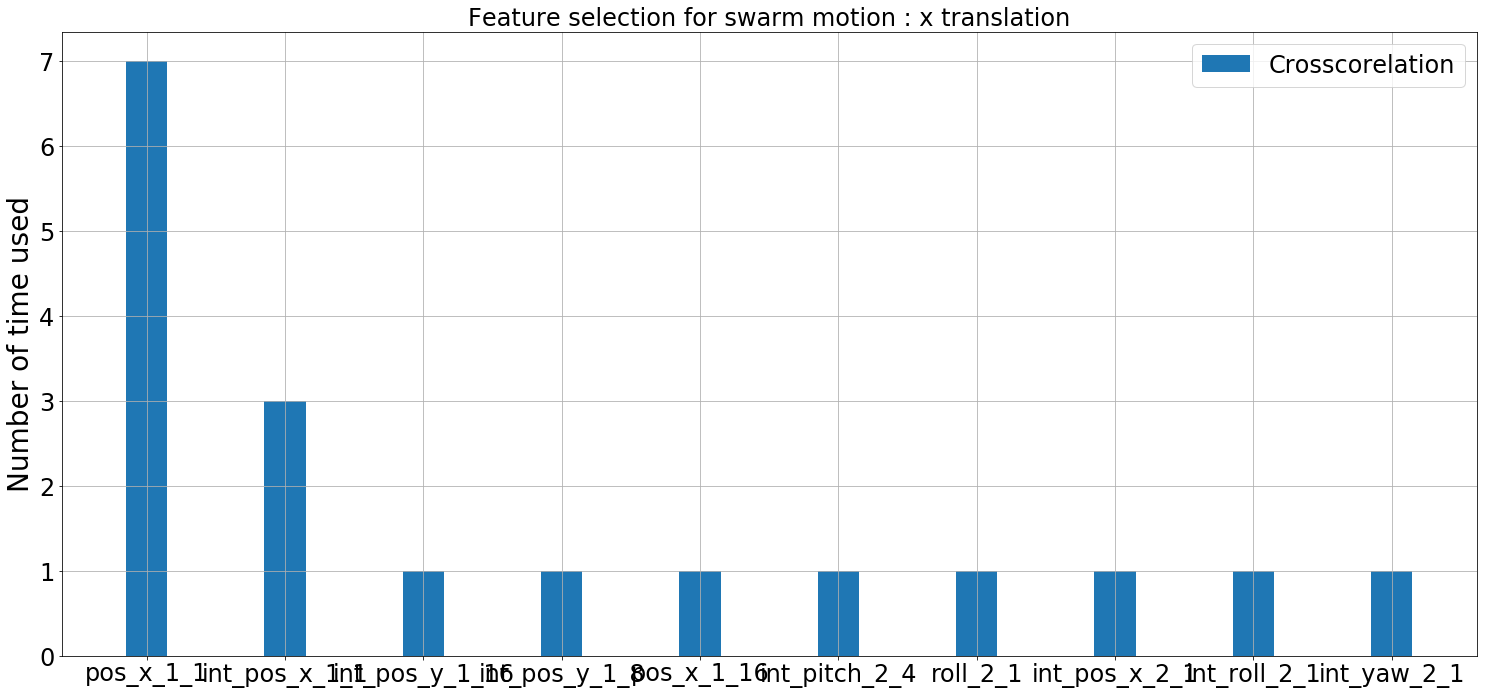

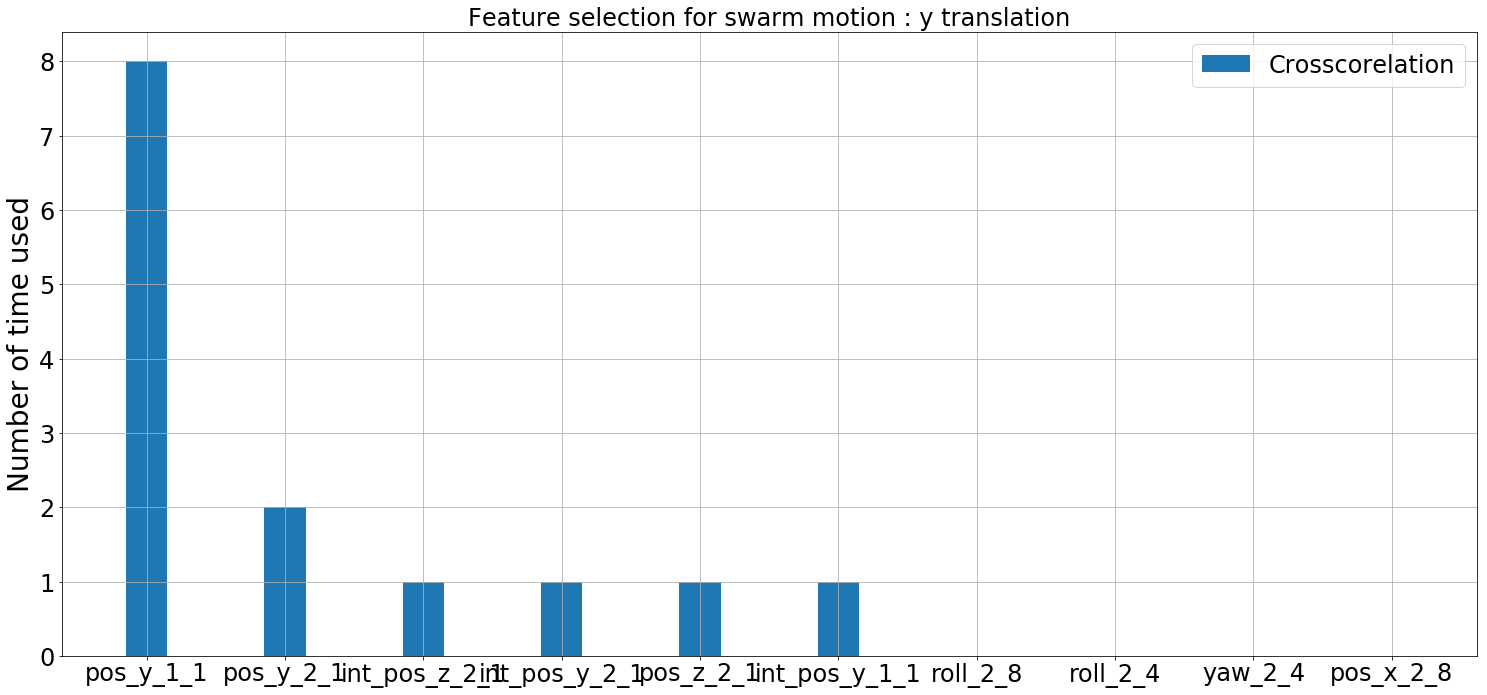

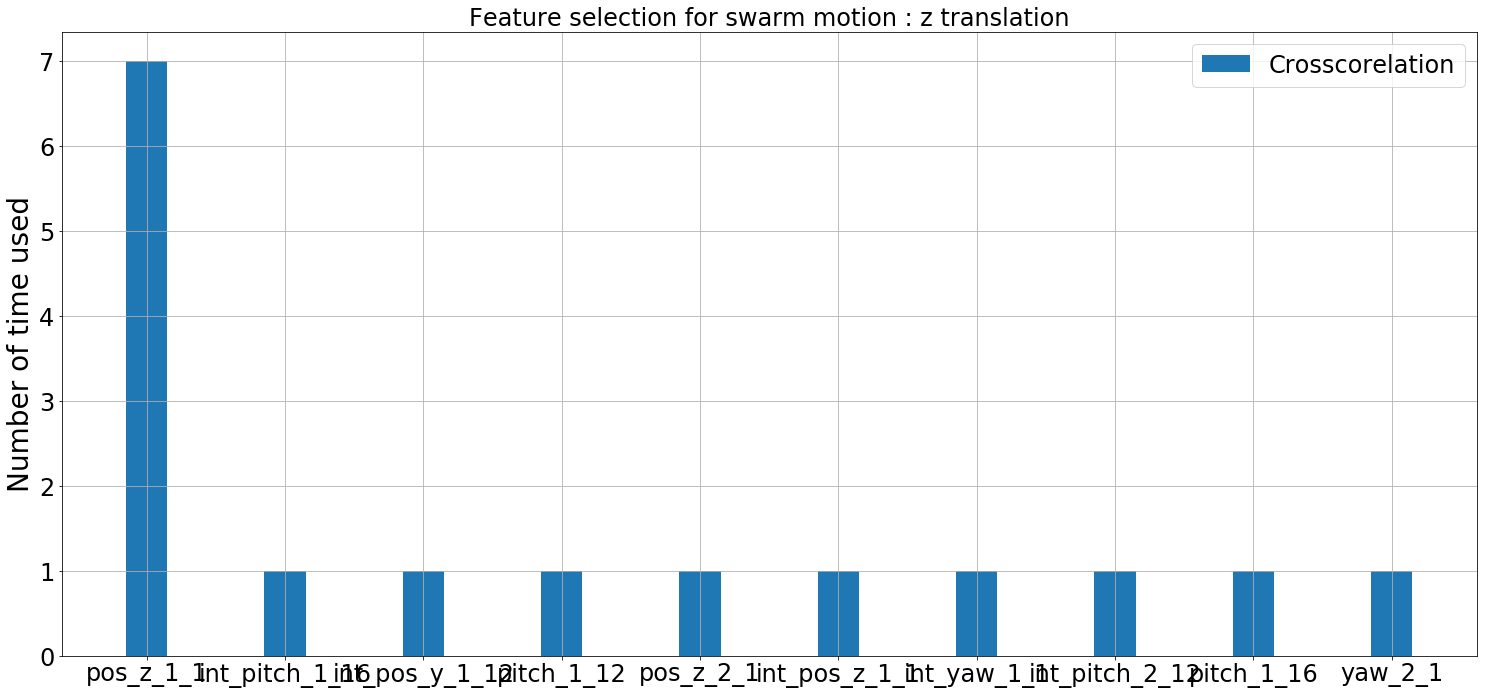

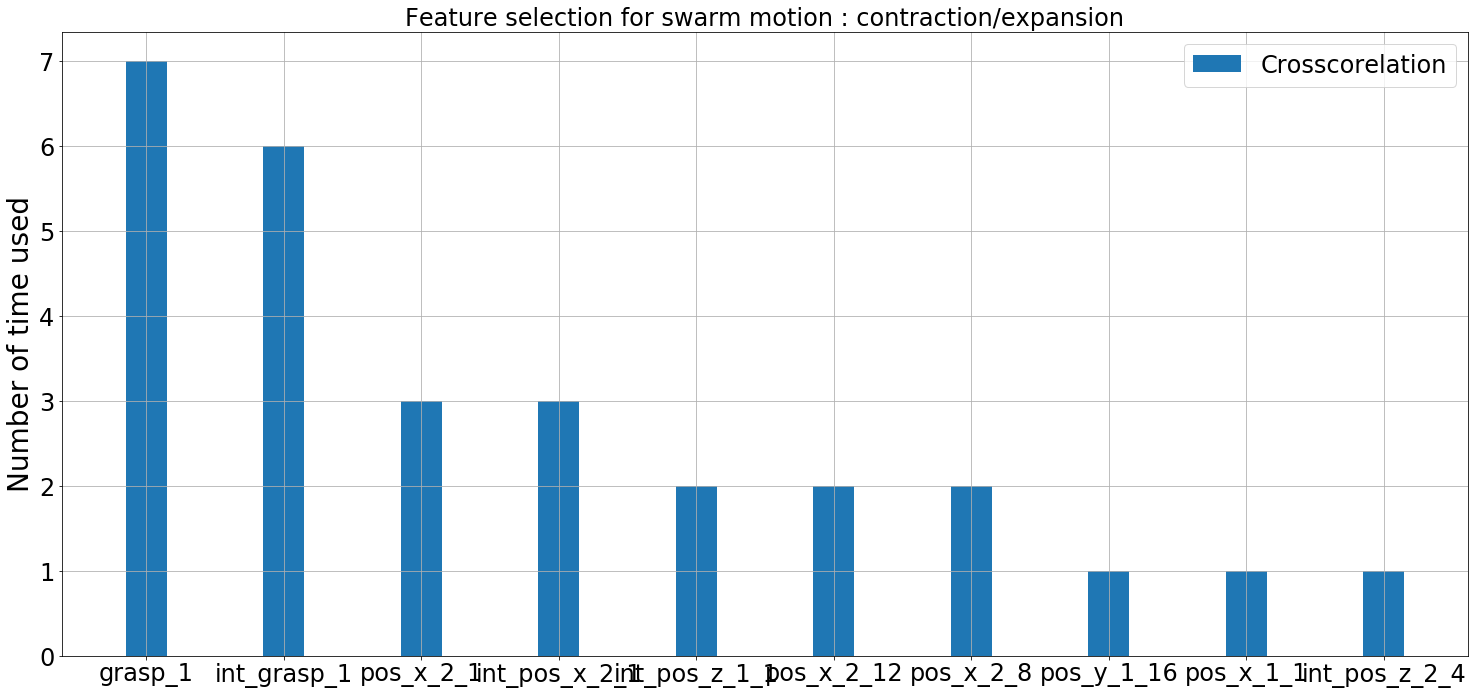

In [128]:
plt.rcParams.update({'font.size': 18})
outputs_labels = ['x translation', 'y translation', 'z translation', 'contraction/expansion']
print(list(coeff[0].keys())[:-1])
for i,out in enumerate(list(coeff[0].keys())[:-1]):
    ind = np.argpartition(list(coef_sum[out].values()), -n_selected)[-n_selected:]
    #ind = ind[np.argsort([list(coeff_mean[out].values())[i] for i in ind])] # To sort the array in ascending order
    ind = ind[np.argsort(-np.array([list(coef_sum[out].values())[i] for i in ind]))] # To sort the array in descending order
    name_ind = np.array(list(coef_sum[out].keys()))[ind]
    labels = name_ind
    coeff_data = [coef_sum[out][n] for n in name_ind]

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(2.1*n_selected,10))
    rects1 = ax.bar(x, coeff_data, width, label='Crosscorelation', capsize=10)
    #rects2 = ax.bar(x + width/2, snr_means, width, yerr=snrStd, label='SNR')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of time used')
    ax.set_title('Feature selection for swarm motion : '+outputs_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    #autolabel(rects1)
    #autolabel(rects2)

    fig.tight_layout()
    plt.grid()
    plt.show()

In [129]:
#print(coef_sum['input1'].keys())
list_right_hand = {}
list_left_hand = {}
list_int_right_hand = {}
list_int_left_hand = {}

for maneuver in coef_sum.keys():
    list_right_hand[maneuver] = {}
    list_left_hand[maneuver] = {}
    list_int_right_hand[maneuver] = {}
    list_int_left_hand[maneuver] = {}
    
    # Palm features :
    list_right_hand[maneuver]["palm"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_1_1'] for x in ['x','y','z']])
    list_left_hand[maneuver]["palm"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_2_1'] for x in ['x','y','z']])
    list_int_right_hand[maneuver]["palm"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_1_1']for x in ['x','y','z']])
    list_int_left_hand[maneuver]["palm"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_2_1'] for x in ['x','y','z']])

    # Palm rotation features :
    list_right_hand[maneuver]["palm_rot"] = np.sum([coef_sum[maneuver][str(x)+'_1_1'] for x in ['roll','pitch','yaw']])
    list_left_hand[maneuver]["palm_rot"] = np.sum([coef_sum[maneuver][str(x)+'_2_1'] for x in ['roll','pitch','yaw']])
    list_int_right_hand[maneuver]["palm_rot"] = np.sum([coef_sum[maneuver]['int_'+str(x)+'_1_1'] for x in ['roll','pitch','yaw']])
    list_int_left_hand[maneuver]["palm_rot"] = np.sum([coef_sum[maneuver]['int_'+str(x)+'_2_1'] for x in ['roll','pitch','yaw']])

    # Finger 1 features :
    list_right_hand[maneuver]["finger 1"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_1_4'] for x in ['x','y','z']])
    list_left_hand[maneuver]["finger 1"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_2_4'] for x in ['x','y','z']])
    list_int_right_hand[maneuver]["finger 1"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_1_4'] for x in ['x','y','z']])
    list_int_left_hand[maneuver]["finger 1"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_2_4'] for x in ['x','y','z']])

    # Finger 2 features :
    list_right_hand[maneuver]["finger 2"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_1_8'] for x in ['x','y','z']])
    list_left_hand[maneuver]["finger 2"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_2_8'] for x in ['x','y','z']])
    list_int_right_hand[maneuver]["finger 2"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_1_8'] for x in ['x','y','z']])
    list_int_left_hand[maneuver]["finger 2"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_2_8'] for x in ['x','y','z']])

    # Finger 3 features :
    list_right_hand[maneuver]["finger 3"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_1_12'] for x in ['x','y','z']])
    list_left_hand[maneuver]["finger 3"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_2_12'] for x in ['x','y','z']])
    list_int_right_hand[maneuver]["finger 3"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_1_12'] for x in ['x','y','z']])
    list_int_left_hand[maneuver]["finger 3"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_2_12'] for x in ['x','y','z']])

    # Finger 4 features :
    list_right_hand[maneuver]["finger 4"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_1_16'] for x in ['x','y','z']])
    list_left_hand[maneuver]["finger 4"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_2_16'] for x in ['x','y','z']])
    list_int_right_hand[maneuver]["finger 4"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_1_16'] for x in ['x','y','z']])
    list_int_left_hand[maneuver]["finger 4"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_2_16'] for x in ['x','y','z']])

    # Finger 5 features :
    list_right_hand[maneuver]["finger 5"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_1_20'] for x in ['x','y','z']])
    list_left_hand[maneuver]["finger 5"] = np.sum([coef_sum[maneuver]['pos_'+str(x)+'_2_20'] for x in ['x','y','z']])
    list_int_right_hand[maneuver]["finger 5"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_1_20'] for x in ['x','y','z']])
    list_int_left_hand[maneuver]["finger 5"] = np.sum([coef_sum[maneuver]['int_pos_'+str(x)+'_2_20'] for x in ['x','y','z']])

    # grasp features :
    list_right_hand[maneuver]["grasp"] = np.sum([coef_sum[maneuver]['grasp_1']])
    list_left_hand[maneuver]["grasp"] = np.sum([coef_sum[maneuver]['grasp_2']])
    list_int_right_hand[maneuver]["grasp"] = np.sum([coef_sum[maneuver]['int_grasp_1']])
    list_int_left_hand[maneuver]["grasp"] = np.sum([coef_sum[maneuver]['int_grasp_2']])

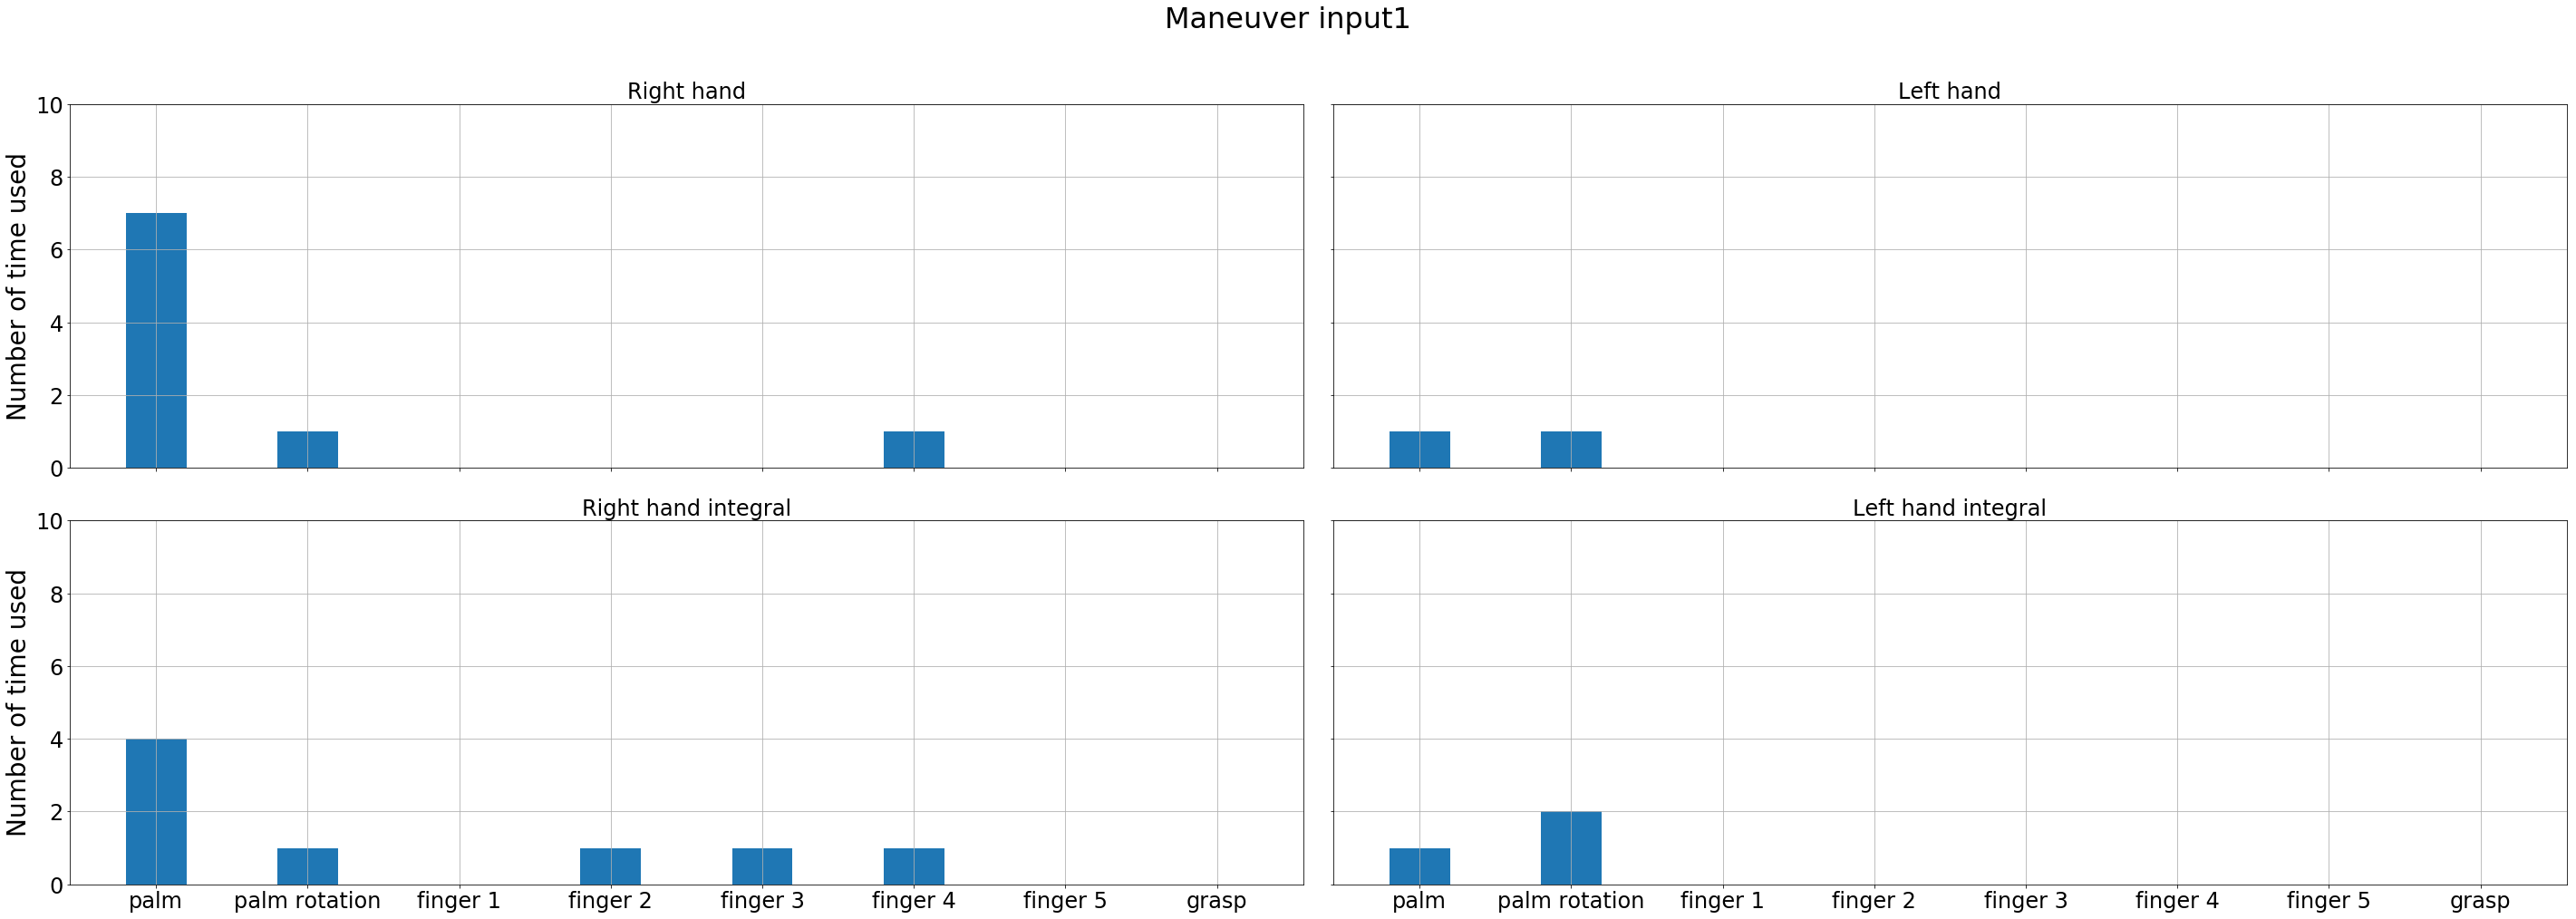

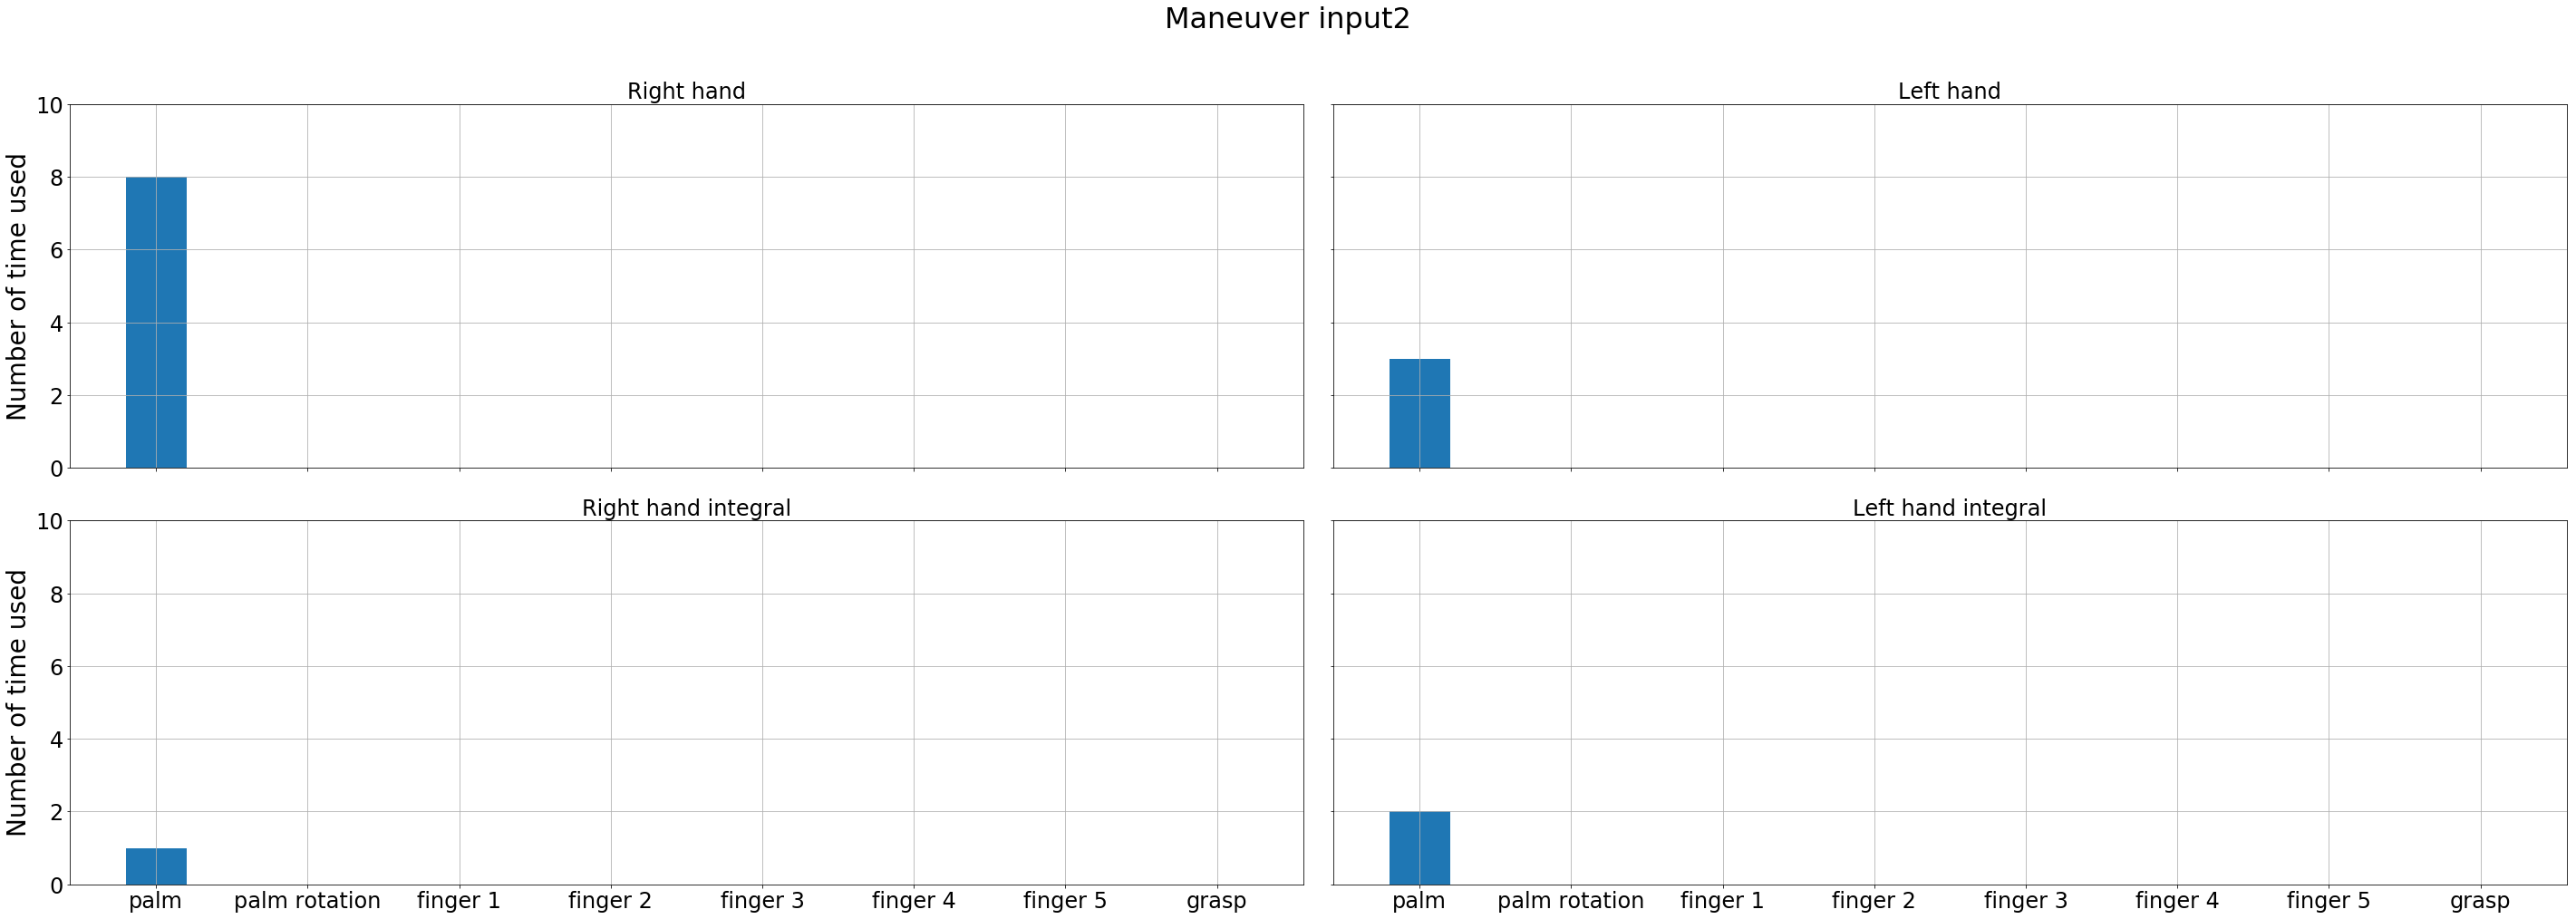

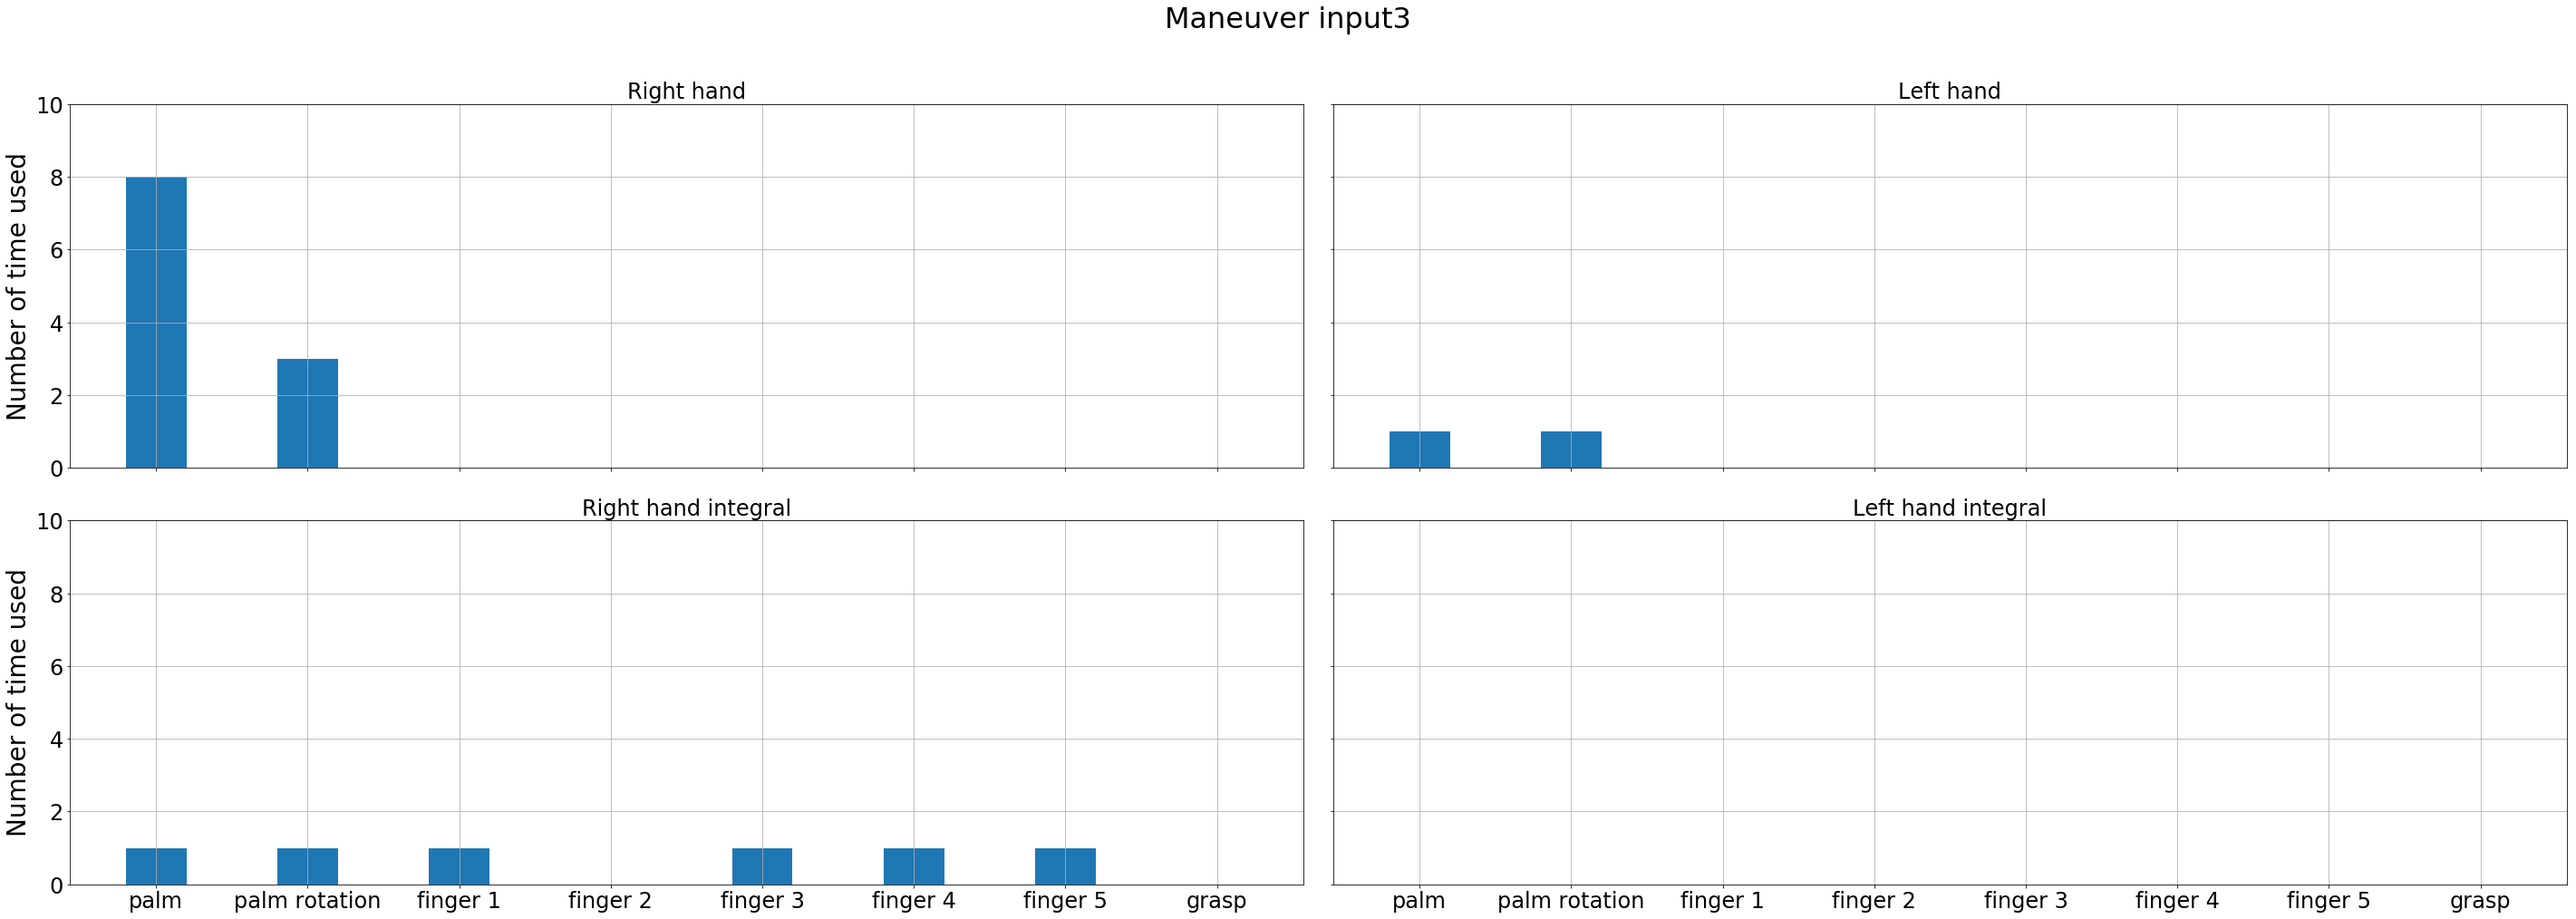

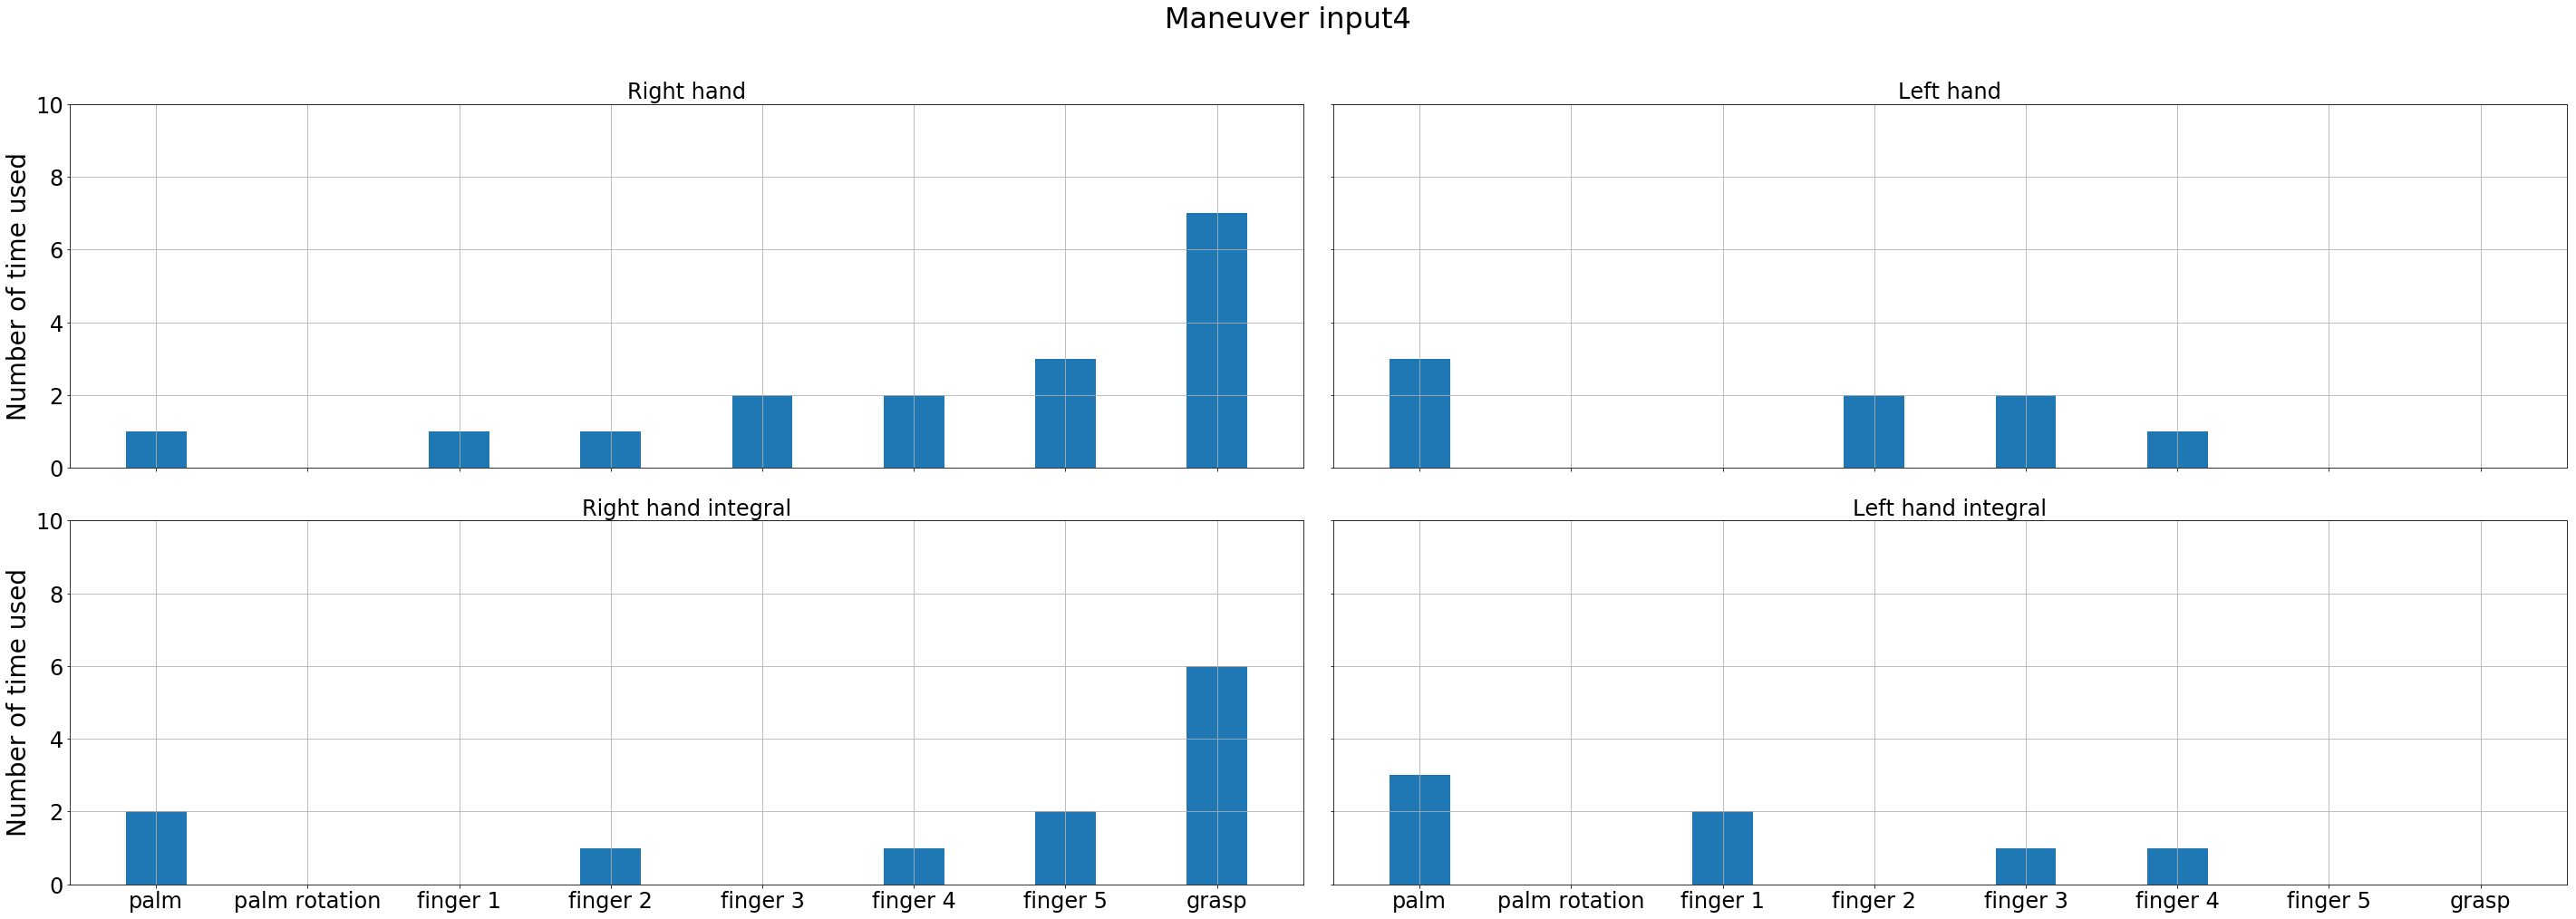

In [130]:
SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

features_names = ['palm', 'palm rotation', 'finger 1', 'finger 2', 'finger 3', 'finger 4', 'finger 5', 'grasp']

x = np.arange(len(features_names))  # the label locations
width = 0.4  # the width of the bars

maneuvers = list(coef_sum.keys())[:-1]

for man in maneuvers:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True, figsize=(5*len(features_names),15))
    st = fig.suptitle(f"Maneuver {man}", fontsize=32)
    
    rects1 = ax1.bar(x, list(list_right_hand[man].values()), width, capsize=10)
    ax1.set_ylabel('Number of time used')
    ax1.set_title('Right hand')
    ax1.set_xticks(x)
    ax1.set_xticklabels(features_names)
    fig.tight_layout()
    ax1.grid()
    ax1.set_ylim([0, 10])

    rects1 = ax2.bar(x, list(list_left_hand[man].values()), width, capsize=10)
    #ax2.set_ylabel('Number of time used')
    ax2.set_title('Left hand')
    ax2.set_xticks(x)
    ax2.set_xticklabels(features_names)
    fig.tight_layout()
    ax2.grid()

    rects1 = ax3.bar(x, list(list_int_right_hand[man].values()), width, capsize=10)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax3.set_ylabel('Number of time used')
    ax3.set_title('Right hand integral')
    ax3.set_xticks(x)
    ax3.set_xticklabels(features_names)
    fig.tight_layout()
    ax3.grid()

    rects1 = ax4.bar(x, list(list_int_left_hand[man].values()), width, capsize=10)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    #ax4.set_ylabel('Number of time used')
    ax4.set_title('Left hand integral')
    ax4.set_xticks(x)
    ax4.set_xticklabels(features_names)
    fig.tight_layout()
    ax4.grid()
    
    #for i, row in enumerate(((ax1, ax2), (ax3, ax4))):
    #    for j, cell in enumerate(row):
    #        if i == len(((ax1, ax2), (ax3, ax4))) - 1:
    #            cell.set_xlabel("noise column: {0:d}".format(j + 1))
    #        if j == 0:
    #            cell.set_ylabel("noise row: {0:d}".format(i + 1))
                
    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)
    
    plt.show()